In [1]:
cd ./projects/foldtree2/


/home/dmoi/projects/foldtree2


In [2]:
import sys
sys.path.append('/home/dmoi/projects/foldtree2')
#read the afdb clusters file
import pandas as pd
import numpy as np
import glob
import os
#autoreload
import pickle
from src import AFDB_tools
import toytree
import tqdm
from matplotlib import pyplot as plt

In [3]:
datadir = '../../datasets/foldtree2/'

In [4]:

#read the afdb rep file
reps = pd.read_table( datadir + 'afdbclusters/1-AFDBClusters-entryId_repId_taxId.tsv', header=None, names=['entryId', 'repId', 'taxId'] )
print( 'reps' , reps.head() )

reps       entryId       repId    taxId
0  A0A009E921  A0A009E921  1310605
1  A0A009F5K6  A0A009E921  1310605
2  A0A009E9H3  A0A009E9H3  1310605
3  A0A484ZLT0  A0A009E9H3    82979
4  A0A009ECR5  A0A009ECR5  1310605


In [5]:
repdirs = '../../datasets/foldtree2/struct_align/'

In [6]:
mkdirs = False
if mkdirs == True:
    #make a structure alignment directory
    if not os.path.exists( 'struct_align' ):
        os.makedirs( 'struct_align' )
    
    #make a directory for each cluster representative
    for rep in reps['repId']:
        if not os.path.exists( datadir +'struct_align/' + rep  ):
            os.makedirs(datadir + 'struct_align/' + rep  )
        if not os.path.exists( datadir+ 'struct_align/' + rep  + '/structs/'):
            os.makedirs( datadir+ 'struct_align/' + rep + '/structs/' )
            

In [7]:
#download n struct members for each cluster
dl_structs = False
if dl_structs == True:
    n = 5
    for rep in tqdm.tqdm(reps.repId.unique() ):
        subdf = reps[ reps['repId'] == rep ]
        if len(subdf) < n:
            n = len(subdf)
        subdf = subdf.sample( n = n  )
        subdf = subdf.head( n )
        #download the structures
        for uniID in subdf['entryId']:
            AFDB_tools.grab_struct(uniID , structfolder=datadir+'struct_align/' + rep  + '/structs/')

In [8]:
#for each folder in struct_align, align the structures with all vs all using foldseek
from src import foldseek2tree
aln_structs = False
if aln_structs == True:
    for rep in tqdm.tqdm(reps.repId.unique() ):
        #align the structures
        foldseek2tree.runFoldseek_allvall_EZsearch( infolder= datadir + 'struct_align/' + rep  + '/structs/', outpath=datadir+'struct_align/' + rep + '/allvall.csv' )


In [21]:
import foldtree2_ecddcd as ft2
import torch
#get all example structures in a directory
structs = glob.glob('families/fsx1/*.pdb')
print(structs)

ndim = 844
converter = ft2.PDB2PyG()


#switch device to cpu


with open( 'encoder_mk3_aa_EMA_64_lowcost_big_transformer_model.pkl' , 'rb' ) as f:
    encoder,decoder = pickle.load( f )

alphabetsize = encoder.vector_quantizer.embedding_dim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

encoder = encoder.to(device)
encoder.eval()


['families/fsx1/6EGU.pdb', 'families/fsx1/5mf1mono.pdb', 'families/fsx1/WP_163487151_Hborinquense.pdb', 'families/fsx1/4GSX.pdb', 'families/fsx1/WP_007110832_Naltunense.pdb', 'families/fsx1/4OJC_model.pdb', 'families/fsx1/2ala.pdb', 'families/fsx1/1OAN.pdb', 'families/fsx1/2I69.pdb', 'families/fsx1/6E18.pdb', 'families/fsx1/WP_049937247_Hnatans.pdb', 'families/fsx1/3n43.pdb', 'families/fsx1/5ow3.pdb', 'families/fsx1/WP_058826362_Haloferax.pdb', 'families/fsx1/1SVB.pdb', 'families/fsx1/fsxA11_monomer.pdb', 'families/fsx1/1rer.pdb', 'families/fsx1/4HJ1.pdb']


HeteroGAE_Encoder(
  (convs): ModuleList(
    (0): ModuleDict(
      (res_backbone_res): TransformerConv(844, 300, heads=1)
      (res_backbonerev_res): TransformerConv(844, 300, heads=1)
      (res_contactPoints_res): TransformerConv(844, 300, heads=1)
      (res_hbond_res): TransformerConv(844, 300, heads=1)
    )
    (1-3): 3 x ModuleDict(
      (res_backbone_res): TransformerConv(300, 300, heads=1)
      (res_backbonerev_res): TransformerConv(300, 300, heads=1)
      (res_contactPoints_res): TransformerConv(300, 300, heads=1)
      (res_hbond_res): TransformerConv(300, 300, heads=1)
    )
  )
  (bn): BatchNorm1d(844, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.01, inplace=False)
  (out_dense): Sequential(
    (0): Linear(in_features=320, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): Tanh()
  )

In [22]:
import importlib
importlib.reload(ft2)
from torch_geometric.data import DataLoader

struct_dat = ft2.StructureDataset('structs_structalign_new.h5')
#struct_dat = ft2.StructureDataset('structs_training.h5')
encoder_loader = DataLoader(struct_dat, batch_size=1, shuffle=True)
#encode the structures
encoder.eval()
encode_alns = False
if encode_alns == True:
    def databatch2list(loader):
        for data in loader:
            data = data.to_data_list()
            for d in data:
                yield d
    encoder_loader = databatch2list(encoder_loader)
    encoder.encode_structures_fasta(encoder_loader , 'aln_encoded.fasta' )

/home/dmoi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [23]:
encoded_fasta = '/home/dmoi/projects/foldtree2/aln_encoded.fasta' 
seqstr = ''
ID = ''
seqdict = {}
with open(encoded_fasta, 'r') as f:
    #read all chars of file into a string
    for line in tqdm.tqdm(f):
        if line[0] == '>' and line[-1] == '\n':
            seqdict[ID] = seqstr
            ID = line[1:].strip()
            seqstr = ''
        else:
            seqstr += line.strip()
del seqdict['']
encoded_df = pd.DataFrame( seqdict.items() , columns=['protid', 'seq'] )
#change index to protid
encoded_df.index = encoded_df.protid
encoded_df = encoded_df.drop( 'protid', axis=1 )
print(encoded_df)

0it [00:00, ?it/s]

25060it [00:00, 980615.73it/s]

                                                          seq
protid                                                       
A0A2R6X032.580:08&8".851!...+ú&1...
A0A843IV79üþý0þ01#4)5...
A0A401PCZ0+"5.ü&@$&20#!85...
A0A419HQC72#82!#!!555...
A0A8B2ZF58  üü0.%@6û@9969,,...
...                                                       ...
H9J978    !2..8@;6û962.,549...
E4Y067    .:0+ú.&8+22".úú555ú5...
A0A1I6D296.:.5&$)&.42&û*)...
A0A164Z1K9 6(ù%ù,9@,ù6.!!5;%;\t)9;\...
A0A0S7G8J7:ú5..ú;%ùþ)...

[12529 rows x 1 columns]


In [24]:
charset = 249
#make fasta is shifted by 1 and goes from 1-248 included
#0x01 – 0xFF excluding > (0x3E), = (0x3D), < (0x3C), - (0x2D), Space (0x20), Carriage Return (0x0d) and Line Feed (0x0a)
#replace 0x22 or " which is necesary for nexus files and 0x23 or # which is also necesary
#z is not used currently...

replace_dict = { '>' : chr(249), '=' : chr(250), '<' : chr(251), '-' : chr(252), ' ' : chr(253) , '\r' : chr(254), '\n' : chr(255) , '"':chr(248) , '#':chr(247)}
rev_replace_dict = { v:k for k,v in replace_dict.items() }
rev_replace_dict_ord = { ord(v):ord(k) for k,v in replace_dict.items() }

print(replace_dict)
print(rev_replace_dict)
print(rev_replace_dict_ord)

{'>': 'ù', '=': 'ú', '<': 'û', '-': 'ü', ' ': 'ý', '\r': 'þ', '\n': 'ÿ', '"': 'ø', '#': '÷'}
{'ù': '>', 'ú': '=', 'û': '<', 'ü': '-', 'ý': ' ', 'þ': '\r', 'ÿ': '\n', 'ø': '"', '÷': '#'}
{249: 62, 250: 61, 251: 60, 252: 45, 253: 32, 254: 13, 255: 10, 248: 34, 247: 35}


In [25]:
encoded_df.seq = encoded_df.seq.map(lambda x : ''.join([ c if c not in replace_dict else replace_dict[c] for c in x]))
print(encoded_df)

                                                          seq
protid                                                       
A0A2R6X032.580:08&8ø.851!...+ú&1...
A0A843IV79üþý0þ01÷4)5...
A0A401PCZ0+ø5.ü&@$&20÷!85...
A0A419HQC72÷82!÷!!555...
A0A8B2ZF58  üü0.%@6û@9969,,...
...                                                       ...
H9J978    !2..8@;6û962.,549...
E4Y067    .:0+ú.&8+22ø.úú555ú5...
A0A1I6D296.:.5&$)&.42&û*)...
A0A164Z1K9 6(ù%ù,9@,ù6.!!5;%;\t)9;\...
A0A0S7G8J7:ú5..ú;%ùþ)...

[12529 rows x 1 columns]


In [30]:
#embedding starts at 0
encoded_df['ord'] = encoded_df.seq.map( lambda x: [ ord(c) for c in x] )
#hex starts at 1
encoded_df['hex2'] = encoded_df.ord.map( lambda x: [ hex(c) for c in x] )
print(encoded_df.head())

                                                          seq  \
protid                                                          
A0A2R6X032.580:08&8ø.851!...+ú&1...   
A0A843IV79üþý0þ01÷4)5...   
A0A401PCZ0+ø5.ü&@$&20÷!85...   
A0A419HQC72÷82!÷!!555...   
A0A8B2ZF58  üü0.%@6û@9969,,...   

                                                          ord  \
protid                                                          
A0A2R6X032  [8, 8, 16, 16, 31, 31, 1, 46, 53, 56, 31, 22, ...   
A0A843IV79  [8, 8, 16, 20, 252, 15, 254, 22, 26, 22, 14, 2...   
A0A401PCZ0  [8, 8, 31, 14, 1, 26, 24, 16, 43, 248, 31, 31,...   
A0A419HQC7  [8, 8, 22, 20, 20, 31, 50, 31, 26, 18, 20, 247...   
A0A8B2ZF58  [3, 21, 2, 7, 17, 252, 252, 48, 46, 2, 37, 4, ...   

                                                         hex2  
protid                                    

In [49]:
from torch_geometric.data import HeteroData
import torch
torch.autograd.set_detect_anomaly(True)


from scipy import sparse

converter = ft2.PDB2PyG()

exampe = encoded_df.iloc[600]
print(exampe)
ords = exampe['ord']
#these are the embedding indices
ords = torch.tensor([ c-1 if c not in rev_replace_dict_ord else rev_replace_dict_ord[c]-1 for c in ords] , dtype=torch.long)
ords = ords.to(device)


seq   55ÿüÿ0:2.582+.02....
ord     [8, 8, 24, 53, 53, 18, 16, 20, 255, 252, 255, ...
hex2    [0x8, 0x8, 0x18, 0x35, 0x35, 0x12, 0x10, 0x14,...
Name: A0A445AIE4, dtype: object


[[ 0.          1.          0.         ...  1.          0.
   1.        ]
 [ 0.84147098  0.54030231  0.8317052  ...  0.99463177  0.10163936
   0.99482131]
 [ 0.90929743 -0.41614684  0.92355454 ...  0.97858472  0.20222599
   0.97933888]
 ...
 [-0.89000935 -0.45594228 -0.09313742 ...  0.99835084 -0.38171806
   0.92427881]
 [-0.8645363   0.50257038  0.77637848 ...  0.98705108 -0.28579815
   0.95828984]
 [-0.04421256  0.99902215  0.95525523 ...  0.96515389 -0.18691813
   0.98237549]]
HeteroData(
  positions={ x=[246, 256] },
  (res, backbone, res)={ edge_index=[2, 245] },
  (res, backbonerev, res)={ edge_index=[2, 245] }
)
tensor([[-20.9958, -15.3223, -41.5425,  ..., -31.1195, -37.1647, -25.2303],
        [-21.1368, -13.6916, -42.5054,  ..., -31.6484, -37.4408, -24.3104],
        [-47.7713, -36.7653, -16.1635,  ..., -62.4533, -55.3332, -44.2072],
        ...,
        [-40.3145, -25.3126, -32.1232,  ..., -47.4895, -51.5545, -14.8503],
        [-41.9645, -34.5037, -36.1049,  ..., -55.9809, -5

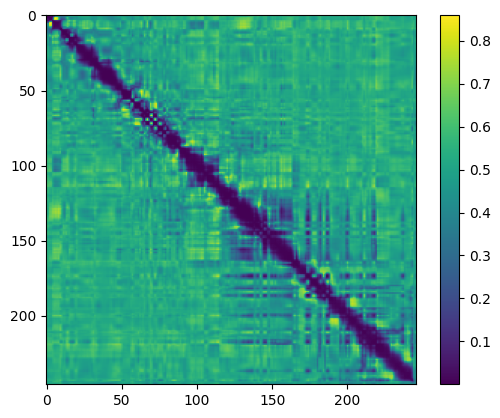

In [50]:


#get aa and contacts
def get_backbone(naa):
    backbone_mat = np.zeros((naa, naa))
    backbone_rev_mat = np.zeros((naa, naa))
    np.fill_diagonal(backbone_mat[1:], 1)
    np.fill_diagonal(backbone_rev_mat[:, 1:], 1)
    return backbone_mat, backbone_rev_mat

def sparse2pairs(sparsemat):
    sparsemat = sparse.find(sparsemat)
    return np.vstack([sparsemat[0],sparsemat[1]])

def decoder_reconstruction2aa( ords , device, verbose = False):
    encoder.eval()
    decoder.eval()
    z = encoder.vector_quantizer.embeddings( ords  )
    edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ] ).T
    #generate a backbone for the decoder
    data = HeteroData()
    backbone, backbone_rev = get_backbone( z.shape[0] )
    backbone = sparse.csr_matrix(backbone)
    backbone_rev = sparse.csr_matrix(backbone_rev)
    backbone = sparse2pairs(backbone)
    backbone_rev = sparse2pairs(backbone_rev)
    positional_encoding = converter.get_positional_encoding( z.shape[0] , 256 )
    print(positional_encoding)

    data['positions'].x = torch.tensor( positional_encoding, dtype=torch.float32)
    data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
    data['res','backbonerev','res'].edge_index = torch.tensor(backbone_rev,  dtype=torch.long )
    
    print(data)
    
    edge_index = edge_index.to( device )

    data = data.to( device )

    z = torch.cat([z, data['positions'].x], dim=1)
    recon_x, edge_probs = decoder(z , edge_index , data.edge_index_dict )
    amino_map = decoder.amino_acid_indices
    revmap_aa = { v:k for k,v in amino_map.items() }
    
    edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
    if verbose == True:
        print( recon_x )
        print( edge_probs )
    aastr = ''.join(revmap_aa[int(idx.item())] for idx in recon_x.argmax(dim=1) )
    return aastr ,edge_probs

aa, edgeprobs = decoder_reconstruction2aa( ords , device = device, verbose = True)
print(aa)
plt.imshow(1-edgeprobs.detach().cpu().numpy())  
plt.colorbar()
plt.show()


In [ ]:
#find union of all sets of characters for sequences
char_set = set()
for seq in encoded_df.seq:
    char_set = char_set.union( set( seq ) )
char_set = list( char_set )
char_set.sort()
print( char_set )
print( len(char_set) )

['\x01', '\x02', '\x03', '\x04', '\x05', '\x06', '\x07', '\x08', '\t', '\x0b', '\x0c', '\x0e', '\x0f', '\x10', '\x11', '\x12', '\x13', '\x14', '\x15', '\x16', '\x17', '\x18', '\x19', '\x1a', '\x1b', '\x1c', '\x1d', '\x1e', '\x1f', '!', '$', '%', '&', '(', ')', '*', '+', ',', '.', '0', '1', '2', '4', '5', '6', '8', '9', ':', ';', '@', '÷', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'þ', 'ÿ']
59


In [ ]:
cols = 'query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qaln,taln'.split(',')
alnfiles = glob.glob(datadir + 'struct_align/*/allvall.csv')
fident_thresh = .3
submat =  np.zeros((256,256))
background_freq = np.zeros(len(char_set))
q_mat = np.zeros((256,256))
seqcount = 0

for rep in tqdm.tqdm(alnfiles ):
    q_mat_chunk = np.zeros((256,256))
    submat_chunk = np.zeros((256,256))
    alncount = 0
    #load the all vs all aln
    aln_df = pd.read_table(rep)
    aln_df.columns = cols
    #load the embedding of the structures
    q = aln_df['query'].unique()
    t = aln_df['target'].unique()
    
    seqset = set()
    representative = rep.split('/')[-2]
    for q in aln_df['query'].unique():
        for t in aln_df['target'].unique():
            if q != t:
                #align the structures
                aln = aln_df[ (aln_df['query'] == q) & (aln_df['target'] == t) ]
                if len(aln)> 0 and aln.fident.iloc[0] < fident_thresh:
                    aln = aln.iloc[0]
                    qaln = aln.qaln
                    taln = aln.taln
                    qaccession = q.split( '.' )[0]
                    taccession = t.split( '.' )[0]

                    if qaccession in encoded_df.index and taccession in encoded_df.index:
                        qz = str(encoded_df.loc[qaccession].seq[aln.qstart-1:aln.qend])
                        tz = str(encoded_df.loc[taccession].seq[aln.tstart-1:aln.tend])

                        if qaccession not in seqset:
                            background_freq += np.array([ qz.count( c ) for c in char_set ])
                            seqset.add( qaccession )
                            seqcount += len(qz)
                        
                        if len( qz) == len( qaln.replace('-','') ) and len( tz) == len( taln.replace('-','') ):
                            qz = iter(qz)
                            tz = iter(tz)

                            #transfer the alignments to the embeddings                    
                            qaln_ft2, taln_ft2 = [], []

                            for q_char in qaln:
                                if q_char == '-':
                                    qaln_ft2.append(None)
                                else:
                                    qaln_ft2.append(ord(next(qz)))
                                   
                            for t_char in taln.strip():
                                if t_char == '-':
                                    taln_ft2.append(None)
                                else:
                                    taln_ft2.append(ord(next(tz)))

                            alnzip = list(zip( qaln_ft2 , taln_ft2 ))
                            alnzip = np.array([ [a[0] , a[1]] for a in alnzip if a[0] is not None and a[1] is not None])
                            #normalize by size of alignment
                            
                            submat_chunk[alnzip[:,0] , alnzip[:,1]] += 1
                            #normalize by size of alignment and number of pairs
                            alncount += 1
                            q_mat_chunk[alnzip[:,0] , alnzip[:,1]] += 1 / len(qaln.replace('-',''))
        if alncount > 0:
            q_mat += (q_mat_chunk / alncount)
            submat += (submat_chunk / alncount)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3691/3691 [00:43<00:00, 84.16it/s]


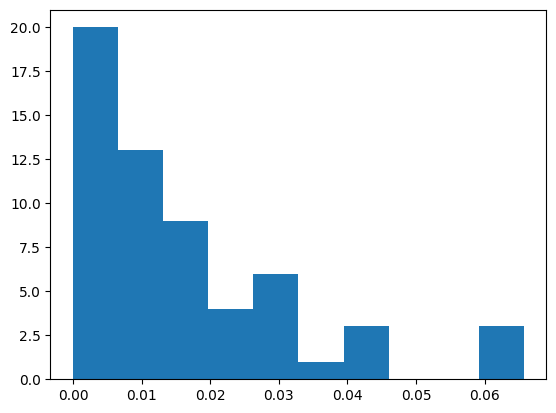

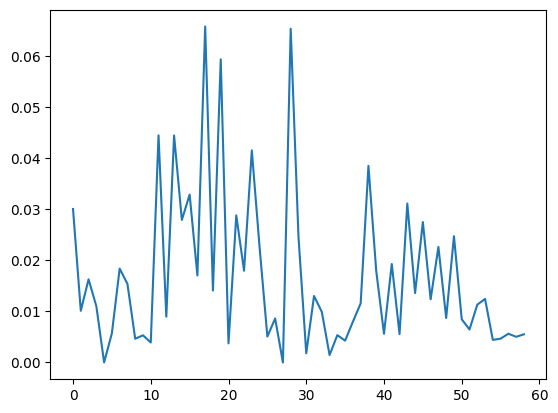

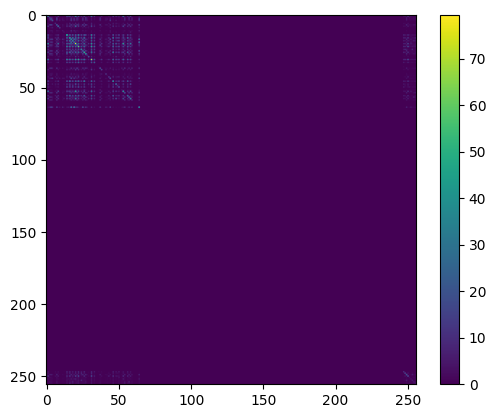

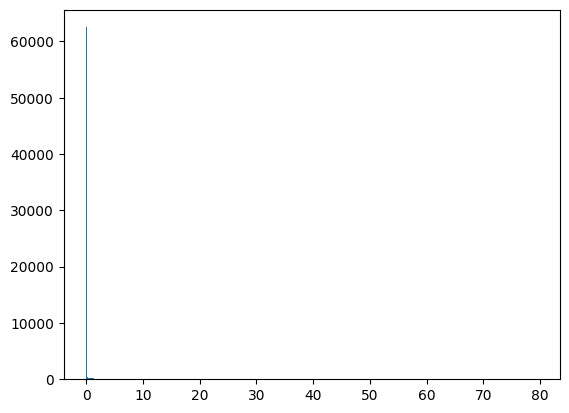

In [ ]:
background_freq = background_freq / np.sum( background_freq )
q_mat = q_mat + q_mat.T
plt.hist( background_freq )
plt.show()
plt.plot( background_freq )
plt.show()

#ploT QMAT
plt.imshow(q_mat)
plt.colorbar()
plt.show()
plt.hist(q_mat.flatten() , bins = 400)
plt.show()


In [ ]:
print( len(background_freq))

59


In [ ]:
#normalize qmat so that each row and column sums to 1


np.fill_diagonal(q_mat, 0 )


for i in range(256):
    if np.sum( q_mat[i,:] ) > 0:
        q_mat[i,:] = q_mat[i,:] / np.sum( q_mat[i,:] )
        q_mat[:,i] = q_mat[i,:]
    else:
        q_mat[i,i] = 1
        q_mat[i,i] = 1


In [ ]:
alphabet = [ord(c) for c in char_set]
sub_qmat = q_mat[alphabet,:]
sub_qmat = sub_qmat[:,alphabet]


In [ ]:
ords = np.array([ ord(c) for c in char_set ])
ords_original = ords.copy()
ords_original = [ i if i not in rev_replace_dict_ord else rev_replace_dict_ord[i] for i in ords ]



print(ords)

print( ords_original)
inputchars = """0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ! " # $ % & ' ( ) * + , / : ; < = > @ [ \ ] ^ _ { | } ~""".split()

revmap_raxml = { c:ords_original[i] for i,c in enumerate(inputchars[:len(char_set)]) }
print(revmap_raxml)


[  1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  33  36  37  38  40  41  42
  43  44  46  48  49  50  52  53  54  56  57  58  59  64 247 248 249 250
 251 252 253 254 255]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 36, 37, 38, 40, 41, 42, 43, 44, 46, 48, 49, 50, 52, 53, 54, 56, 57, 58, 59, 64, 35, 34, 62, 61, 60, 45, 32, 13, 10]
{'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 11, 'A': 12, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 33, 'U': 36, 'V': 37, 'W': 38, 'X': 40, 'Y': 41, 'Z': 42, '!': 43, '"': 44, '#': 46, '$': 48, '%': 49, '&': 50, "'": 52, '(': 53, ')': 54, '*': 56, '+': 57, ',': 58, '/': 59, ':': 64, ';': 35, '<': 34, '=': 62, '>': 61, '@': 60, '[': 45, '\\': 32, ']': 13, '^': 10}


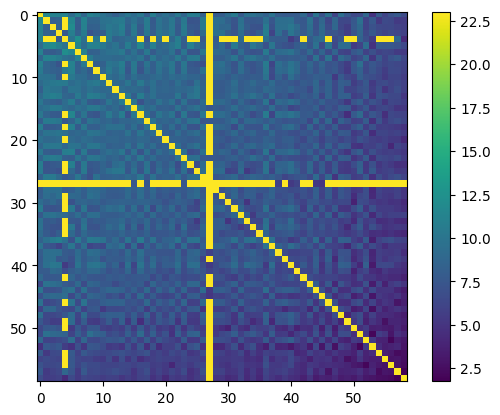

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^']


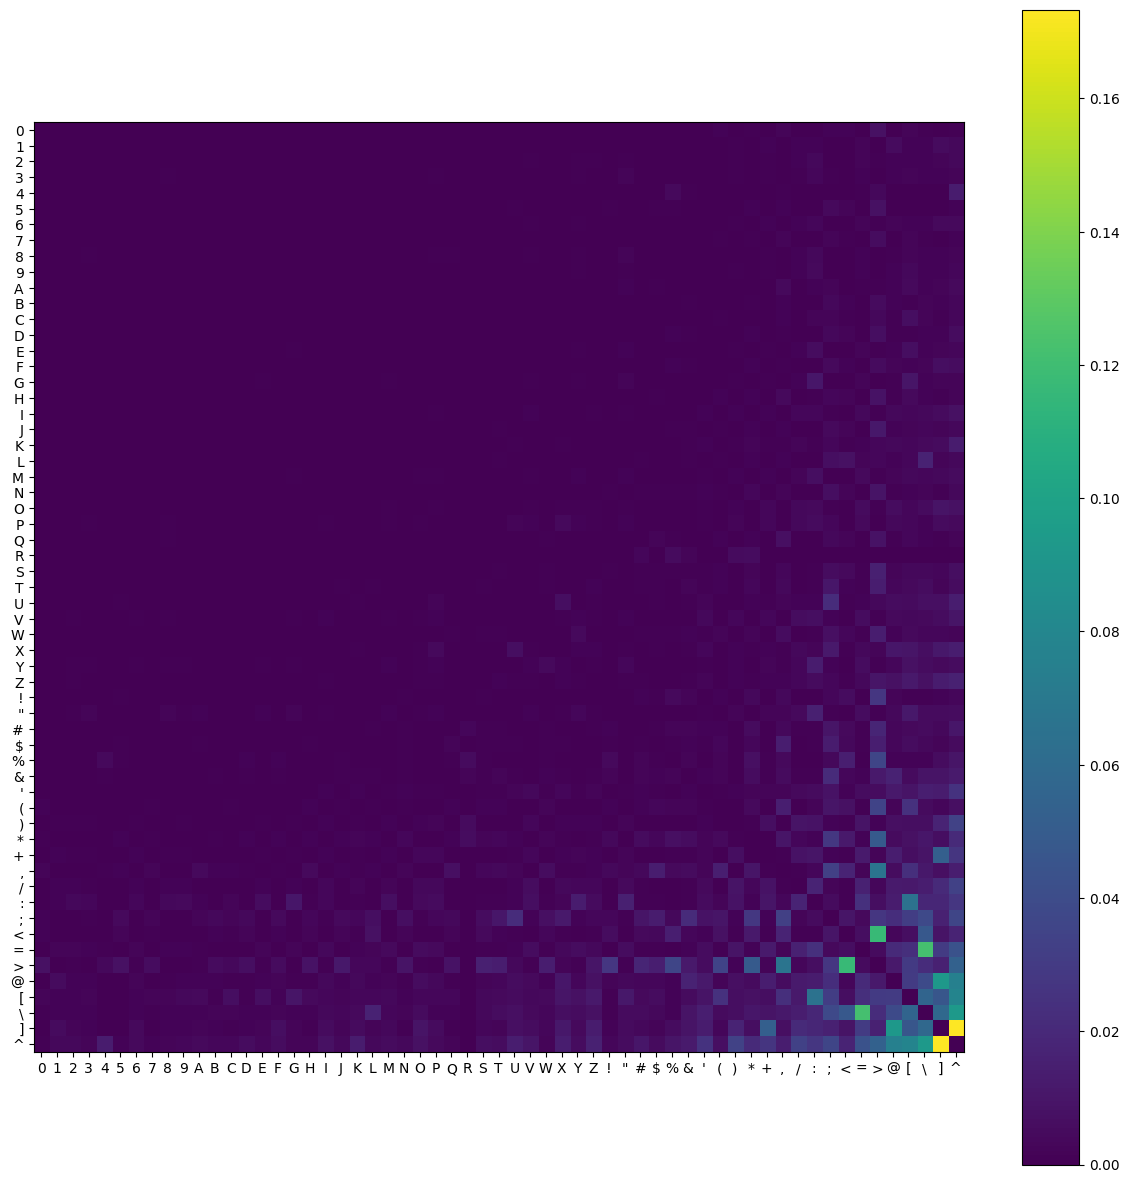

In [ ]:
#divide the columns of qmat by the sum of the column

plt.imshow(-np.log(sub_qmat+10**-10))
plt.colorbar()
plt.show()

inputchars = """0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ! " # $ % & ' ( ) * + , / : ; < = > @ [ \ ] ^ _ { | } ~""".split()
alphabet = inputchars[:len(char_set)]

print( alphabet )
plt.figure( figsize=(15,15))

plt.imshow(sub_qmat)
#make tick marks alphabet
plt.xticks( range(len(alphabet)), alphabet)
plt.yticks( range(len(alphabet)), alphabet)
plt.colorbar()
plt.show()

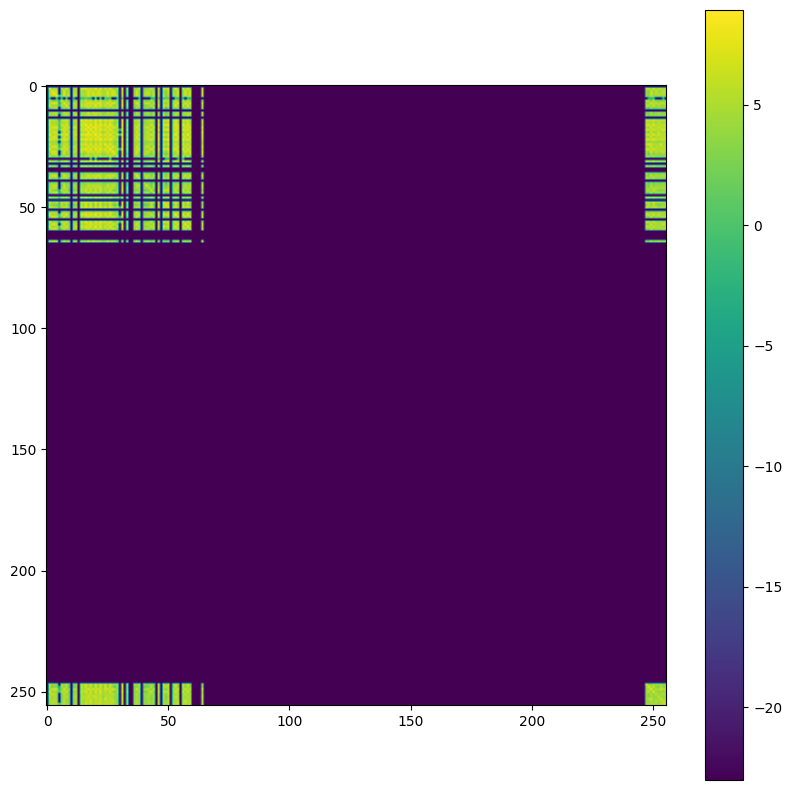

(array([6.2206e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 9.0000e+00, 3.6000e+01, 3.0000e+01,
        5.8000e+01, 6.3500e+02, 1.3530e+03, 9.5700e+02, 2.5100e+02]),
 array([-23.02585093, -21.42851498, -19.83117904, -18.23384309,
        -16.63650714, -15.0391712 , -13.44183525, -11.8444993 ,
        -10.24716335,  -8.64982741,  -7.05249146,  -5.45515551,
         -3.85781957,  -2.26048362,  -0.66314767,   0.93418827,
          2.53152422,   4.12886017,   5.72619611,   7.32353206,
          8.92086801]),
 <BarContainer object of 20 artists>)

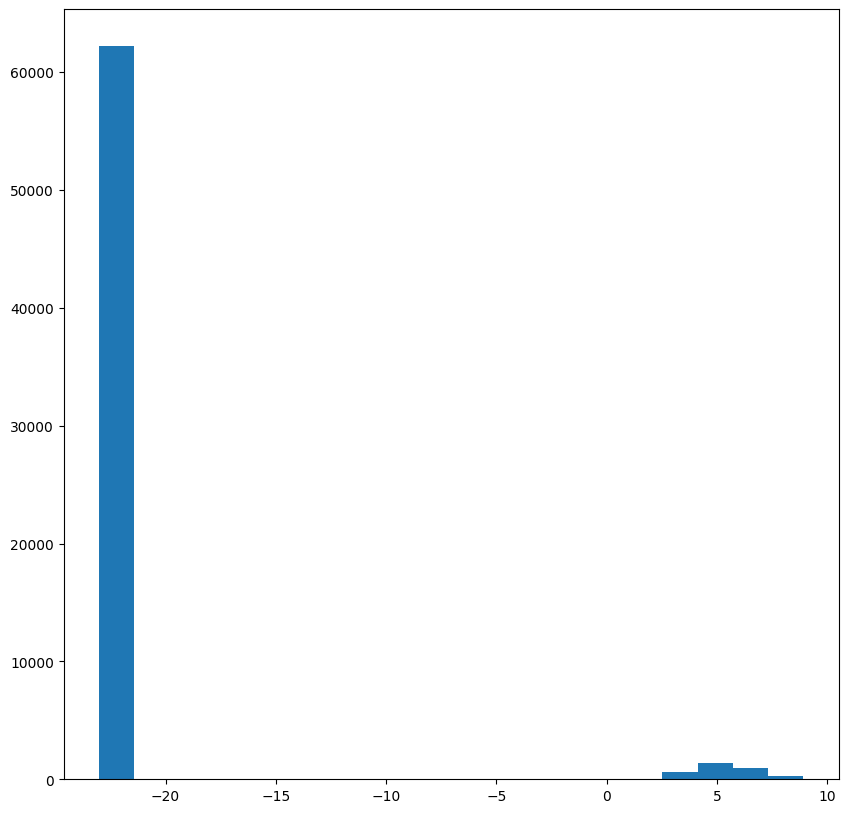

In [ ]:
plt.figure( figsize=(10,10))
plt.imshow(np.log(submat + 10**-10 ) )
plt.colorbar()

plt.show()
plt.figure( figsize=(10,10))

plt.hist( np.log( submat.flatten() + 10 **-10 )  , bins = 20)

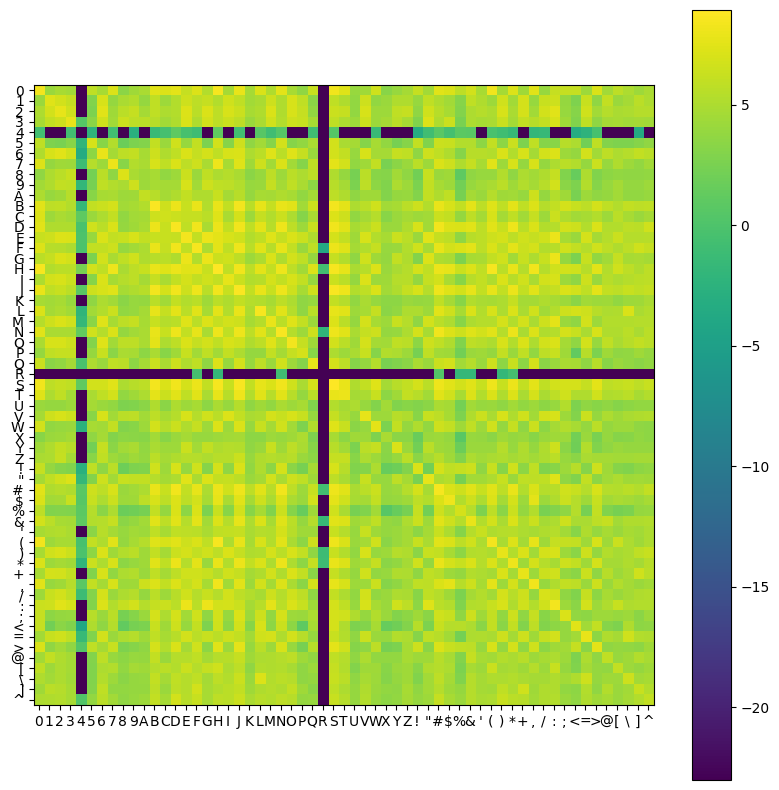

In [ ]:
#remove zero rows and columns for visualization
alphabet = [ord(c) for c in char_set]
vismat = submat[alphabet, : ]
vismat = vismat[ :, alphabet ]
plt.figure( figsize=(10,10))
plt.imshow(np.log(vismat + 10**-10 ) )
#set the tick marks to the alphabet
plt.xticks( range(len(alphabet)), inputchars[:len(char_set)])
plt.yticks( range(len(alphabet)), inputchars[:len(char_set)])
plt.colorbar()

In [ ]:
#mafft matrix file example max 248 char

"""
0x01 0x01 2   # (comment)
0x1e 0x1e 2
0x1f 0x1f 2
0x21 0x21 2   # ! × !
0x41 0x41 2   # A × A
0x42 0x42 2   # B × B
0x43 0x43 2   # C × C
"""

def formathex(hexnum):
    if len(hexnum) == 3:
        return hexnum[0:2] + '0' + hexnum[2]
    else:
        return hexnum

def output_mafft_matrix( submat , outpath='mafft_submat.mtx' ):
    with open(outpath, 'w') as f:
        for i in range(submat.shape[0]):
            for j in range(submat.shape[1]):
                if i <= j:
                    
                    stringi = chr(i)
                    stringj = chr(j)
                    
                    if stringi in replace_dict.keys():
                        stringi = replace_dict[stringi]
                    if stringj in replace_dict.keys():
                        stringj = replace_dict[stringj]
                    
                    i = ord(stringi)
                    j = ord(stringj)

                    hexi = formathex(hex(i))
                    hexj = formathex(hex(j))
                    
                    if submat[i,j] > 1:
                        f.write( f'{hexi} {hexj} {submat[i,j]} \n ')# '+ stringi + 'x' + stringj + ' \n' )
                    #else:
                    #    f.write( f'{hexi} {hexj} {0.0} # '+ stringi + 'x' + stringj + ' \n' )
output_mafft_matrix( submat , outpath='mafft_submat.mtx' )


In [ ]:
#align the structures
# mafft --textmatrix maff_submat.mtx input > output

In [ ]:
import subprocess
import Bio.PDB as PDB
def run_mafft_textaln( infasta , outaln , matrix='mafft_submat.mtx' ):
    cmd = f'mafft --text --localpair --maxiterate 1000 --textmatrix {matrix} {infasta}  > {outaln}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outaln

def mafft_hex2fasta( intext , outfasta ):
    #% /usr/local/libexec/mafft/hex2maffttext input.hex > input.ASCII
    cmd = f'/usr/lib/mafft/lib/mafft/hex2maffttext {intext} > {outfasta}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outfasta    


def fasta2hex( intext , outfasta ):
    #% /usr/local/libexec/mafft/maffttext2hex input.hex > input.ASCII
    cmd = f'/usr/lib/mafft/lib/mafft/maffttext2hex {intext} > {outfasta}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outfasta    

def normal_mafft( infasta , outaln ):
    cmd = f'mafft --anysymbol {infasta} > {outaln}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outaln



def struct2sequence(structfile):
    parser = PDB.PDBParser()
    structure = parser.get_structure('struct', structfile)
    seq = ''
    for model in structure:
        for chain in model:
            for residue in chain:
                if PDB.is_aa(residue):
                    seq += residue.get_resname()
    return seq

In [ ]:
import glob
structs = glob.glob('families/fsx1/*.pdb')


In [ ]:
#make normal fasta

with open( 'fsx1_example.fasta', 'w') as f:
    for s in structs:
        seq =  struct2sequence(s)
        if len(seq)>0:
            identifier = s.split('/')[-1].split('.')[0]
            f.write('>' + identifier + '\n' + seq + '\n')


/home/dmoi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6734.
  warnings.warn(
/home/dmoi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record ' ' at line 19
  warnings.warn(
/home/dmoi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3009
  warnings.warn(
/home/dmoi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3807
  warnings.warn(
/home/dmoi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3025
  warnings.warn(
/home/dmoi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarn

In [ ]:

def loader( structlist , converter):
    for struct in tqdm.tqdm(structlist):
        try:
            data = converter.struct2pyg( struct )
            if data:
                yield data
        except:
            print('error')
            continue

loader = loader( structs , converter )
encoder.encode_structures_fasta( loader , 'fsx1_encoded.fasta')


0it [00:00, ?it/s]

1it [00:00,  1.32it/s]

2it [00:01,  1.40it/s]

3it [00:01,  1.57it/s]

4it [00:02,  1.45it/s]

5it [00:03,  1.31it/s]

6it [00:04,  1.47it/s]

7it [00:04,  1.57it/s]

8it [00:05,  1.65it/s]

9it [00:06,  1.39it/s]



error


Exception ignored in: <generator object loader at 0x7efb1e7fcdd0>
Traceback (most recent call last):
  File "/home/dmoi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/Bio/PDB/Atom.py", line 386, in get_full_id
    return self.parent.get_full_id() + ((self.name, self.altloc),)
RuntimeError: generator ignored GeneratorExit
 17%|████████████████████▎                                                                                                     | 3/18 [01:09<05:46, 23.08s/it]
10it [00:07,  1.02it/s]

11it [00:08,  1.18it/s]

12it [00:08,  1.27it/s]

13it [00:09,  1.27it/s]

14it [00:10,  1.39it/s]

15it [00:11,  1.39it/s]

16it [00:11,  1.51it/s]

17it [00:12,  1.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.48it/s]
17it [00:12,  1.39it/s]


'fsx1_encoded.fasta'

In [ ]:
aln = normal_mafft( 'fsx1_example.fasta' , 'fsx1_example.aln' )


mafft --anysymbol fsx1_example.fasta > fsx1_example.aln


inputfile = orig
17 x 2364 - 1152 p
nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 1404 ambiguous characters.
    1 / 17
done.

Constructing a UPGMA tree (efffree=0) ... 
   10 / 17
done.

Progressive alignment 1/2... 
STEP    13 / 16 
Reallocating..done. *alloclen = 5837
STEP    16 / 16 
done.

Making a distance matrix from msa.. 
    0 / 17
done.

Constructing a UPGMA tree (efffree=1) ... 
   10 / 17
done.

Progressive alignment 2/2... 
STEP    13 / 16 
Reallocating..done. *alloclen = 5803
STEP    16 / 16 
done.

disttbfast (aa) Version 7.453
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scori

In [ ]:
#load alignment into dataframe
aln_data = {}
with open('fsx1_example.aln', 'r') as f:
    for line in f:
        if line[0] == '>':
            ID = line[1:].strip()
            aln_data[ID] = ''
        else:
            aln_data[ID] += line.strip()
normal_aln_df = pd.DataFrame( aln_data.items() , columns=['protid', 'seq'] )
print(normal_aln_df)
print(len(normal_aln_df.seq.iloc[0]))

                     protid                                                seq
0                      6EGU  ---------------CYSSERGLULEUILEGLNALASERSERARGI...
1                  5mf1mono  ---------VALILEALASERGL-YARGL--------------EUG...
2                      4GSX  ------------ARGCYSVALGLYILEGL---------YASNARGA...
3   WP_007110832_Naltunense  ---------------ILETHRGLUTYRTHR------SERASNSERG...
4                4OJC_model  --------------GLYPHEP-ROLEUGL---------------UG...
5                      2ala  ------------------TYRGL-UH--------------------...
6                      1OAN  ---------METARGCYSILEGLYILESE---------RASNARGA...
7                      2I69  ---------PHEASNCYSLEUGLYMETSE---------RASNARGA...
8                      6E18  ------GLUVALILEALASERGL-YARGL--------------EUG...
9      WP_049937247_Hnatans  ------------ALAALASER---TYRLYS------SERASNSERG...
10                     3n43  ------------GLYGLYTYRGL-UH--------------------...
11                     5ow3  ILEGLNILELEUSERLYSSERLY

In [ ]:
#convert fsx1_encoded.fasta to fsx1_encoded.hex
encoded_fasta = 'fsx1_encoded.fasta'
with open(encoded_fasta, 'r') as f:
    #read all chars of file into a string
    with open('fsx1_encoded.hex' , 'w') as g:
        for line in f:
            if line[0] == '>':
                g.write(line )
            else:
                hexstr = ''
                for char in line:
                    hexstr += formathex(hex(ord(char)))[2:] + ' '
                g.write(hexstr + '\n')

with open( 'fsx1_encoded.hex', 'r') as f:
    for line in f:
        print(line)

>6EGU

29 29 07 36 11 13 3b 19 07 07 25 fc 03 2a 29 16 21 2a 15 29 34 11 07 1b 03 19 11 13 25 19 1b 07 40 1b 19 36 19 29 11 0b 11 15 1b 40 2e ff 39 3b 03 15 2c 11 15 13 15 03 40 07 07 36 11 07 29 25 36 1b 3b 07 04 09 03 1b 07 2c 07 f9 15 29 11 07 07 25 25 29 23 14 01 0e 36 26 23 01 32 25 29 14 07 09 25 39 fb 36 03 16 19 36 0c 16 3a 01 0e 10 16 03 03 0b 25 36 02 15 29 2c 36 3b 29 0e 0e 23 0e 26 0e 26 3a 32 40 02 f9 07 29 11 2c 40 1c 03 04 11 3b 07 40 34 15 36 19 11 25 40 2c 02 29 13 fe 09 40 1c 15 11 03 11 36 13 03 39 0c 39 1b 07 40 07 03 13 39 11 1b 19 07 07 07 25 2c 21 fb 09 1b 07 40 07 11 07 11 fe 1f 36 0e 35 16 0e 16 02 07 2c 07 2c 13 36 07 fd 1b 15 1b 04 19 13 40 39 36 f9 0c 07 10 13 fd 34 17 0e 3a 11 1b 36 13 25 29 02 07 ff 07 07 40 11 07 19 1c 36 07 29 11 25 1f f9 02 11 13 07 04 15 f9 0b 13 39 3b 11 36 29 03 03 02 11 fc 39 f9 0c 40 40 2c ff 25 1b 07 11 f9 3b 03 34 02 39 15 03 2c 19 19 16 2e 0e 32 25 1b 40 3b 19 2c 07 15 1b 07 40 3b 19 39 11 03 11 0b 2c fe 02 2c 36 40 39 2c 40 1b 

In [ ]:
#go to ascii encoding
hexfile = 'fsx1_encoded.hex'
asciifile = mafft_hex2fasta( hexfile , 'fsx1_encoded.ASCII' )

/usr/lib/mafft/lib/mafft/hex2maffttext fsx1_encoded.hex > fsx1_encoded.ASCII


In [ ]:
#align wti mafft
run_mafft_textaln( asciifile , 'fsx1_econded.aln.ascii' , matrix='mafft_submat.mtx' )

mafft --text --localpair --maxiterate 1000 --textmatrix mafft_submat.mtx fsx1_encoded.ASCII  > fsx1_econded.aln.ascii


outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
Score(=0x1,=0x1)=4177.940065
Score(=0x1,=0x2)=62.652426
Score(=0x1,=0x3)=120.108681
Score(=0x1,=0x4)=94.153255
Score(=0x1,=0x6)=348.765428
Score(=0x1,=0x7)=110.970804
Score(=0x1=0x8)=1383.964870
Score(=0x1,	=0x9)=29.291991
Score(=0x1,�=0xff)=124.664989
Score(=0x1,=0xb)=75.365750
Score(=0x1,=0xc)=122.691240
Score(=0x1,�=0xfe)=68.604097
Score(=0x1,=0xe)=1867.796752
Score(=0x1,=0xf)=1308.382307
Score(=0x1,=0x10)=1910.213711
Score(=0x1,=0x11)=436.212789
Score(=0x1,=0x12)=1311.265052
Score(=0x1,=0x13)=185.747246
Score(=0x1,=0x14)=4620.069284
Score(=0x1,=0x15)=104.737661
Score(=0x1,=0x16)=2629.819902
Score(=0x1,=0x17)=96.745631
Score(=0x1,=0x18)=1216.868638
Score(=0x1,=0x19)=173.773594
Score(=0x1,=0x1a)=1914.903038
Score(=0x1,=0x1b)=114.837501
Score(=0x1,=0x1c)=35.836798
Score(=0x1,=0x1d)=541.485715
Score(=0x1,=0x1f)=3752.162004
Score(=0x1,�=0xfd)=150.383555
Sc

'fsx1_econded.aln.ascii'

In [ ]:
#change from mafft text 2 hex
aln_hexfile = fasta2hex( 'fsx1_econded.aln.ascii' , 'fsx1_encoded.aln.hex' )


/usr/lib/mafft/lib/mafft/maffttext2hex fsx1_econded.aln.ascii > fsx1_encoded.aln.hex


In [ ]:

with open( aln_hexfile , 'r') as f:
    for l in f:
        print(l)

>6EGU

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 29 29 07 36 11 13 3b 19 07 07 25 fc 03 2a 29 -- -- 16 21 -- -- -- -- -- -- 2a 15 29 34 11 07 1b 03 19 11 13 25 19 1b 07 40 1b 

19 36 19 29 -- -- -- -- -- 11 0b 11 15 1b 40 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 2e ff 39 3b 03 15 2c 11 15 13 15 03 40 07 07 36 11 07 29 25 36 1b 3b 07 

04 09 03 1b 07 2c -- -- -- 07 f9 15 29 11 07 07 25 25 29 23 14 01 0e 36 -- -- -- -- -- -- -- -- -- -- -- -- 26 23 01 32 25 29 14 07 09 25 39 fb 36 03 16 19 36 0c 16 3a 01 -- -- -- 

-- -- -- 0e 10 16 03 03 0b 25 36 02 15 29 2c 36 3b 29 0e 0e 23 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 0e 26 0e 26 -- 3a 32 40 

02 f9 07 29 11 2c 40 1c 03 04 11 3b 07 -- -- 40 34 15 36 19 11 25 40 2c 02 29 13 fe 09 40 1c 15 11 03 11 36 13 03 39 0c 39 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 

-- -- -- -- 1b 07 40 07 03 13 39 11 1b 19 07 07 07 25 -- -- -- 2c 21 fb 09 1b 07 40

In [ ]:
#read the aln hex file
with open( aln_hexfile , 'r') as f:
    seqdict = {}
    seqstr = ''
    ID = ''
    for line in f:
        if line[0] == '>':
            seqdict[ID] = seqstr
            ID = line[1:].strip()
            seqstr = ''
        else:
            seqstr += line + ' '
    seqdict[ID] = seqstr
alndf = pd.DataFrame( seqdict.items() , columns=['protid', 'hex_aln'] )
alndf.index = alndf.protid
alndf.drop( 'protid' , axis = 1 , inplace = True)
alndf.drop( ''  , inplace = True)
alndf['ord_aln'] = alndf.hex_aln.map( lambda x: [ int(c,16) if c!='--' else '-' for c in x.split() ] )
alndf['seq_aln'] = alndf.ord_aln.map( lambda x: ''.join([ chr(c) if c !='-' else '-' for c in x ]) )
print(alndf)

                                                                   hex_aln  \
protid                                                                       
6EGU                     -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
5mf1mono                 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
4GSX                     -- -- -- -- -- -- -- -- -- -- -- -- -- -- 25 2...   
WP_007110832_Naltunense  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
4OJC_model               0e 0e 3a 18 14 10 10 2e 3a 12 0e 14 0c 25 19 3...   
2ala                     -- -- 04 04 36 -- -- -- -- -- -- -- -- -- -- -...   
1OAN                     -- -- -- -- -- -- -- -- -- -- -- -- -- 0b 0b 2...   
2I69                     -- -- -- -- -- -- -- -- -- -- -- -- -- 2c 2c 0...   
6E18                     -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
WP_049937247_Hnatans     -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
3n43                     1b 1b 1b 04 36 -- -- -- -- -- -- -- -- 

In [ ]:
#re-encode to 72 char
remap = { c:i for i,c in enumerate(char_set)}
print(remap)

{'\x01': 0, '\x02': 1, '\x03': 2, '\x04': 3, '\x05': 4, '\x06': 5, '\x07': 6, '\x08': 7, '\t': 8, '\x0b': 9, '\x0c': 10, '\x0e': 11, '\x0f': 12, '\x10': 13, '\x11': 14, '\x12': 15, '\x13': 16, '\x14': 17, '\x15': 18, '\x16': 19, '\x17': 20, '\x18': 21, '\x19': 22, '\x1a': 23, '\x1b': 24, '\x1c': 25, '\x1d': 26, '\x1e': 27, '\x1f': 28, '!': 29, '$': 30, '%': 31, '&': 32, '(': 33, ')': 34, '*': 35, '+': 36, ',': 37, '.': 38, '0': 39, '1': 40, '2': 41, '4': 42, '5': 43, '6': 44, '8': 45, '9': 46, ':': 47, ';': 48, '@': 49, '÷': 50, 'ø': 51, 'ù': 52, 'ú': 53, 'û': 54, 'ü': 55, 'ý': 56, 'þ': 57, 'ÿ': 58}


In [ ]:
alndf['remap_int'] = alndf.seq_aln.map(lambda x : [ remap[c] if c in remap else '-' for c in x ] )

#NEXUS
inputchars = """0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ! " # $ % & ' ( ) * + , / : ; < = > @ [ \ ] ^ _ { | } ~"""

symbols = {i:s for i,s in enumerate( inputchars.split() ) }
print( len( symbols) )
alndf['remap_symbols'] = alndf['remap_int'].map( lambda x : ''.join([ symbols[c] if c in symbols else '-' for c in x ]) )
print(alndf.remap_symbols)

64
protid
6EGU                       ------------------YY6)EG/M66V[2ZY--JT------ZIY...
5mf1mono                   ----------------------::GM6OVE)IY:CFB0T^^E]Y/)...
4GSX                       --------------VVY:O[O1V+":)---------BE6------O...
WP_007110832_Naltunense    -----------------------GG2)-------3ZJ!J^AA]--O...
4OJC_model                 BB,LHDD#,FBHAVM)==PY6I2=G:VM/ZJ*&S7JJ[S------V...
2ala                       --33)----------------------------------------X...
1OAN                       -------------99VY[O[61V+":)---------O:J------O...
2I69                       -------------""1YHO761V+"E)---------OCJ------O...
6E18                       ---------------------)):GM6OVE)IY::FB0T)^E]Y/)...
WP_049937247_Hnatans       -----------------------MMM6-------$#J!J^AA+--O...
3n43                       OOO3)----------------------------------------P...
5ow3                       --------------------GG/GE6I6IE)IY^#TJFJB@E@Y62...
WP_058826362_Haloferax     -----------------------22:2-------$DJ&J

In [ ]:
#output remap symbols column to fasta
with open('fsx1_encoded.aln.remap.fasta', 'w') as f:
    for i in alndf.index:
        f.write('>' + i + '\n' + alndf.loc[i].remap_symbols + '\n')


In [ ]:

bg_raxml = np.zeros( len(inputchars.split()) )
sub_raxml = np.zeros(( len(inputchars.split()) , len(inputchars.split()) ))

bg_raxml[:len(char_set)] = background_freq
sub_raxml[:len(char_set),:len(char_set)] =  sub_qmat



In [ ]:
def raxml_matrix( matrix, background_frequencies, outfile = "raxml_custom_matrix.txt"):
    # Create the substitution matrix file
    #lower triangular matrix
    with open(outfile, "w") as f:
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[0]):
                if j < i:
                    #format to 6 decimal places
                    f.write(f" {matrix[i,j]:.6f}")
            f.write("\n")
        # Add the frequencies
        for i, freq in enumerate(background_frequencies):
            f.write(f"{freq:.6f} ")
        f.write("\n")
    return outfile

print(sub_qmat.shape)

outmatrix = raxml_matrix( sub_qmat , background_freq,  outfile = "raxml_custom_matrix.txt")

with open('raxml_custom_matrix.txt', 'r') as f:
    for line in f:
        print(line)

(59, 59)


 0.000009

 0.000014 0.000272

 0.000014 0.000197 0.000219

 0.000014 0.000000 0.000000 0.000421

 0.000091 0.000011 0.000006 0.000020 0.000053

 0.000015 0.000321 0.000390 0.000235 0.000005 0.000012

 0.000172 0.000014 0.000015 0.000026 0.000073 0.000101 0.000016

 0.000015 0.000170 0.000248 0.000680 0.000000 0.000015 0.000252 0.000028

 0.000028 0.000171 0.000237 0.000297 0.000034 0.000016 0.000232 0.000120 0.000346

 0.000056 0.000060 0.000078 0.000315 0.000000 0.000035 0.000091 0.000100 0.000240 0.000151

 0.000111 0.000054 0.000034 0.000029 0.000032 0.000099 0.000060 0.000104 0.000045 0.000033 0.000079

 0.000273 0.000038 0.000052 0.000055 0.000208 0.000053 0.000055 0.000132 0.000060 0.000105 0.000147 0.000119

 0.000109 0.000026 0.000018 0.000025 0.000160 0.000196 0.000033 0.000124 0.000021 0.000027 0.000056 0.000151 0.000093

 0.000041 0.000174 0.000255 0.000335 0.000091 0.000023 0.000229 0.000060 0.000392 0.000550 0.000269 0.000043 0.000143 0.000033

 0.000102 0.0000

In [54]:
#raxml cmd using subprocess
import subprocess
def run_raxml_ng(fasta_file, matrix_file, nsymbols, output_prefix , iterations = 20 ):
    raxml_cmd ='./raxml-ng  --model MULTI'+str(nsymbols)+'_GTR{'+matrix_file+'}+I+G --redo  --all --bs-trees '+str(iterations)+' --seed 12345 --threads 8 --msa '+fasta_file+' --prefix '+output_prefix 
    print(raxml_cmd)
    subprocess.run(raxml_cmd, shell=True)
    return None


def run_raxml_ng_normal(fasta_file, output_prefix, iterations = 20):
    raxml_cmd ='./raxml-ng  --model LG+I+G  --redo --all --bs-trees ' +str(iterations)+' --seed 12345 --threads 8 --msa '+fasta_file+' --prefix '+output_prefix 
    print(raxml_cmd)
    subprocess.run(raxml_cmd, shell=True)
    return None


#ancestral reconstruction
#raxml-ng --ancestral --msa ali.fa --tree best.tre --model HKY --prefix ASR

def run_raxml_ng_ancestral_struct(fasta_file, tree_file, matrix_file, nsymbols, output_prefix):
    model = 'MULTI'+str(nsymbols)+'_GTR{'+matrix_file+'}+I+G'
    raxml_cmd ='./raxml-ng  --redo --ancestral --msa '+fasta_file+' --tree '+tree_file+' --model '+model+' --prefix '+output_prefix 
    print(raxml_cmd)
    subprocess.run(raxml_cmd, shell=True)
    return None

def run_raxml_ng_ancestral_normal(fasta_file, tree_file, model = 'LG+I+G', output_prefix='ASR'):
    raxml_cmd ='./raxml-ng  --ancestral --msa '+fasta_file+' --tree '+tree_file+' --model '+model+' --prefix '+output_prefix 
    print(raxml_cmd)
    subprocess.run(raxml_cmd, shell=True)
    return None

def madroot( treefile  ):
    mad_cmd = f'./madroot/mad {treefile} '
    print(mad_cmd)
    subprocess.run(mad_cmd, shell=True)
    return treefile+'.rooted'

In [55]:

run_raxml_ng('fsx1_encoded.aln.remap.fasta'  ,'raxml_custom_matrix.txt' , len(char_set) , 'fsx1_example' )


NameError: name 'char_set' is not defined

In [56]:
run_raxml_ng_ancestral_struct(fasta_file='fsx1_encoded.aln.remap.fasta', tree_file= 'fsx1_example.raxml.bestTree', matrix_file='raxml_custom_matrix.txt', nsymbols=len(char_set), output_prefix='ancestral_1st')

NameError: name 'char_set' is not defined

In [57]:
#turn the ancestral state file into a fasta

def ancestral2fasta( ancestral_file , outfasta ):
    with open( outfasta , 'w') as g:        
        with open( ancestral_file , 'r') as f:
            for l in f:
                words = l.split('	')
                if len(words) == 2:
                    identifier, seq = words
                    g.write('>' + identifier + '\n' + seq + '\n')
    return outfasta

outfasta = ancestral2fasta('ancestral_1st.raxml.ancestralStates' , 'ASR.ancestral.fasta' )
with open(outfasta, 'r') as f:
    for l in f:
        print(l)    


>Node1

BBS3HDD#HFBHA6M++=OY6)EG/M66VG22Y62DB:JBAE12IYVE6O2MEGVMO6:OM)MYIOI:2E9EIO:YF1JHSS1I2)JJD(SFFNWMI^+/2I"EIGI2:66)E6YV)O/6382O6"I2:6=IYE66VVYUE:B)2I1ES+36YI+3WU:@VYH68V+@)2JM)AJA06KBOSSBDJ229V)1IY")/YBBQ+Y3S0QFFTHBFJJV)2O66382V"81SZLFBWOWYA@:1=6YE":P23E/66S:'I)MEV:"1Y[+8:PIE2E)G2+"+2CSJPB1$J23JLSL38H2II1GO6:62G+EOM666VM21"Z18O6:6E6E]S)B(JO616"6"G)E36=OT319+30SXE6IO3MG:+)=HA6DG\'*B8"EO)GVY16^BJH+E38I6OBHSSB61811M)2E:)"IM:PMII9+:6:E6MPV9SBDBSHPC&1OL0I9JJDXDJDE1OIMM1)6YEVS=JOHSFES#JQH#SIBNBSELE37HTO39BO6"VE1V6E6EB3=6"S6MEGAISS"OY/G6211EG63I=9G+/E)Y22@PESS6MA2VVEGFD0D+="::")BEZ329Y6SZ6Y2VO6E=/2'1+YVAMO26I2"MMJ#B&VO2GG:/M"6IO6:/M+E2E9"]1"):+":OMM:6Y+MM"E1E2OY36W@MOMV:Y"2JSJJS/E6G262O2O6E6MP1I+O6EPG:E=6)1O2I6M)YP=O+)SVII#S0FG1IGYPGG"321B+/Y/GEPAZ:\)C)))"936Y]O+)V=EE:IO2EGM]]\,]]V')MOO)62:"SS668KH0C2@#FBJ6GB63I#SSGK3)YCSS



>Node2

OO33)DD#HFBHA6MVY=PY6)EGGM66VE2IY62JBSJBAE12IX62:9=1::O1O6YOM)MMIOI:2"=3IMXYF1JHS[^I2)JJD(SFFNWMLO36=E2E/9/::)26E)=2E1E)3G2Y)3I2::=6=3:IWWOM6)WJ2I)I=+3/YI:3

In [58]:
#read the probabilities into a dataframe$
probdf = pd.read_csv('ancestral_1st.raxml.ancestralProbs', sep = '\t')
print(probdf.head())

ParserError: Error tokenizing data. C error: EOF inside string starting at row 6197

In [59]:
#transform the fasta to a dataframe
aln_data = {}
with open(outfasta, 'r') as f:
    for line in f:
        if line[0] == '>':
            ID = line[1:].strip()
            aln_data[ID] = ''
        else:
            aln_data[ID] += line.strip()
ancestral_df = pd.DataFrame( aln_data.items() , columns=['protid', 'seq'] )
#use rev map to convert back to ord
ancestral_df['ord'] = ancestral_df.seq.map( lambda x: [ revmap_raxml[c] if c in revmap_raxml else '-' for c in x ] )

print(ancestral_df)

print( ancestral_df.ord.iloc[0])

NameError: name 'revmap_raxml' is not defined

In [60]:
#import pytorch geometric hetero data
from torch_geometric.data import HeteroData 
from scipy import sparse

#map each of the characters from raxml to the embedding 
def get_backbone(naa):
    backbone_mat = np.zeros((naa, naa))
    backbone_rev_mat = np.zeros((naa, naa))
    np.fill_diagonal(backbone_mat[1:], 1)
    np.fill_diagonal(backbone_rev_mat[:, 1:], 1)
    return backbone_mat, backbone_rev_mat

def sparse2pairs(sparsemat):
    sparsemat = sparse.find(sparsemat)
    return np.vstack([sparsemat[0],sparsemat[1]])

def ancestral_reconstruction2aa( ords , verbose = False):
    encoder.eval()
    decoder.eval()
    
    ords = torch.tensor(ords).to(device)
    z = encoder.vector_quantizer.embeddings( ords  )
    edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ] ).T
    #generate a backbone for the decoder
    data = HeteroData()
    backbone, backbone_rev = get_backbone( z.shape[0] )
    backbone = sparse.csr_matrix(backbone)
    backbone_rev = sparse.csr_matrix(backbone_rev)
    backbone = sparse2pairs(backbone)
    backbone_rev = sparse2pairs(backbone_rev)
    data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
    data['res','backbonerev','res'].edge_index = torch.tensor(backbone_rev,  dtype=torch.long )
    data = data.to( device )
    recon_x, edge_probs = decoder(z , edge_index , data.edge_index_dict )
    
    edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
    if verbose == True:
        print( recon_x )
        print( edge_probs )
    aastr = ''.join(revmap_aa[int(idx.item())] for idx in recon_x.argmax(dim=1) )
    return aastr ,edge_probs

#ancestral_df['aa_reconstruction']= ancestral_df.ord.map( lambda x: ancestral_reconstruction2aa( x  ) )
aatest,edgeprobs = ancestral_reconstruction2aa( ancestral_df.ord.iloc[2] , verbose = True)
print(aatest)
plt.imshow(np.log(1-edgeprobs.detach().cpu().numpy()))  
plt.colorbar()
plt.show()
plt.imshow(1-edgeprobs.detach().cpu().numpy())  
plt.colorbar()
plt.show()


AttributeError: 'DataFrame' object has no attribute 'ord'

In [61]:
print(converter.aaindex)
revmap_aa = { i:c for i,c in enumerate(converter.aaindex) }
print(revmap_aa)

{'A': 0, 'C': 4, 'D': 3, 'E': 6, 'F': 13, 'G': 7, 'H': 8, 'I': 9, 'K': 11, 'L': 10, 'M': 12, 'N': 2, 'P': 14, 'Q': 5, 'R': 1, 'S': 15, 'T': 16, 'V': 19, 'W': 17, 'Y': 18}
{0: 'A', 1: 'C', 2: 'D', 3: 'E', 4: 'F', 5: 'G', 6: 'H', 7: 'I', 8: 'K', 9: 'L', 10: 'M', 11: 'N', 12: 'P', 13: 'Q', 14: 'R', 15: 'S', 16: 'T', 17: 'V', 18: 'W', 19: 'Y'}


In [62]:
with open('fsx1_example.aln' , 'r') as f:
    filestr= f.read()
    filestr = filestr.replace('U','A')
    filestr = filestr.replace('O','A')
    
with open('fsx1_example.aln' , 'w') as f:
    f.write(filestr)

In [63]:
#run normal raxml on aln of protein sequence
run_raxml_ng_normal('fsx1_example.aln' , 'fsx1_example_normal' )

./raxml-ng  --model LG+I+G  --redo --all --bs-trees 20 --seed 12345 --threads 8 --msa fsx1_example.aln --prefix fsx1_example_normal

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: 11th Gen Intel(R) Core(TM) i9-11900K @ 3.50GHz, 8 cores, 62 GB RAM

RAxML-NG was called at 31-Jul-2024 16:10:44 as follows:

./raxml-ng --model LG+I+G --redo --all --bs-trees 20 --seed 12345 --threads 8 --msa fsx1_example.aln --prefix fsx1_example_normal

Analysis options:
  run mode: ML tree search + bootstrapping (Felsenstein Bootstrap)
  start tree(s): random (10) + parsimony (10)
  bootstrap replicates: parsimony (20)
  random seed: 12345
  tip-inner: 

In [64]:
ft2_bs = 'fsx1_example.raxml.support'
#root the tree
madroot(ft2_bs)


#tre = toytree.tree(ft2_bs, format= 0)
#tre.draw(node_labels='support' ,  tip_labels_align=True, tip_labels_colors='r',  width=800, height=800 , scalebar= True )
tre = toytree.tree(ft2_bs+'.rooted')
#print the root node
root = tre.treenode.get_children()[0]
#get all leaf names

leaves = root.get_leaf_names()



tre = toytree.tree(ft2_bs, format= 0)
tre.root(names=leaves)

tre.draw( show_root=True ,  tip_labels_align=True, tip_labels_colors='r',  width=800, height=800 , scalebar= False,
    
    tip_labels_style={"font-size": "22px"},
    node_labels="support",
    node_labels_style={"font-size": "22px"},
    node_markers="r3x2",
    node_sizes=12,
    )
print(tre.get_tip_labels())

./madroot/mad fsx1_example.raxml.support 

MAD phylogenetic rooting

Analyzing file 'fsx1_example.raxml.support'...
>> [MAD=0.054_AI=0.960_CCV=5.53%_N=1/1]

Minimal ancestor deviation, MAD = 0.054
           Ambiguity index,  AI = 0.960
                  Clock CV, CCV = 5.53%
Rooted tree written to 'fsx1_example.raxml.support.rooted'


    - Please cite DOI:10.1038/s41559-017-0193

unrecognized arguments skipped: ['show_root']
check the docs, argument names may have changed.
['WP_058826362_Haloferax', 'WP_049937247_Hnatans', 'WP_007110832_Naltunense', 'fsxA11_monomer', '5mf1mono', '6E18', '5ow3', '1rer', '2ala', '3n43', '6EGU', '4HJ1', '1OAN', '4GSX', '2I69', '1SVB', '4OJC_model']


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="800.0px" viewBox="0 0 800.0 800.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t733a5323d92d4baa916c9748de4f0ceb"> 100 75 100 100 100 100 100 100 95 60 35 95 40 100 WP_058826362_Haloferax WP_049937247_Hnatans WP_007110832_Naltunense fsxA11_monomer 5mf1mono 6E18 5ow3 1rer 2ala 3n43 6EGU 4HJ1 1OAN 4GSX 2I69 1SVB 4OJC_model

In [65]:
ft2_bs = 'fsx1_example_normal.raxml.support'
tre = toytree.tree(ft2_bs)
#root the tree
madroot(ft2_bs)
#tre = toytree.tree(ft2_bs, format= 0)
#tre.draw(node_labels='support' ,  tip_labels_align=True, tip_labels_colors='r',  width=800, height=800 , scalebar= True )
tre = toytree.tree(ft2_bs+'.rooted')
#print the root node
root = tre.treenode.get_children()[0]
#get all leaf names

leaves = root.get_leaf_names()



tre = toytree.tree(ft2_bs, format= 0)
tre.root(names=leaves)

#make the tree face left

tre.draw( show_root=True ,  tip_labels_align=True, tip_labels_colors='r',  width=800, height=800 , scalebar= False,
    layout='l',
    tip_labels_style={"font-size": "22px"},
    node_labels="support",
    node_labels_style={"font-size": "22px"},
    node_markers="r3x2",
    node_sizes=12,
    
    )

print(tre.get_tip_labels())



./madroot/mad fsx1_example_normal.raxml.support 

MAD phylogenetic rooting

Analyzing file 'fsx1_example_normal.raxml.support'...
>> Warning: Trees with repeating branch lengths are suspicious (3 repeating values).
>> [MAD=0.062_AI=0.889_CCV=4.94%_N=1/1]

Minimal ancestor deviation, MAD = 0.062
           Ambiguity index,  AI = 0.889
                  Clock CV, CCV = 4.94%
Rooted tree written to 'fsx1_example_normal.raxml.support.rooted'


    - Please cite DOI:10.1038/s41559-017-0193

unrecognized arguments skipped: ['show_root']
check the docs, argument names may have changed.
['2ala', '1rer', '3n43', '6E18', '5mf1mono', 'WP_049937247_Hnatans', 'WP_058826362_Haloferax', 'fsxA11_monomer', 'WP_007110832_Naltunense', '4GSX', '1AAN', '2I69', '1SVB', '6EGA', '4HJ1', '5ow3', '4AJC_model']


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="800.0px" viewBox="0 0 800.0 800.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t71e63a835e5e47f3a1d649e852b105b9"> 100 85 100 100 100 85 100 100 100 100 100 50 80 100 2ala 1rer 3n43 6E18 5mf1mono WP_049937247_Hnatans WP_058826362_Haloferax fsxA11_monomer WP_007110832_Naltunense 4GSX 1AAN 2I69 1SVB 6EGA 4HJ1 5ow3 4AJC_model